In [3]:
import numpy as np
import pandas as pd
import os

# Reading Data

In [4]:
import json

with open(r'intents.json') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])

In [5]:
df

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."
...,...,...,...
82,fact-51,[I'm feeling overwhelmed and don't know what t...,"[Feeling overwhelmed is tough, but you're not ..."
83,fact-52,[I'm struggling to find joy in things I used t...,[It's common to experience a loss of interest ...
84,fact-53,[I feel like I'm constantly on edge and can't ...,[Constantly feeling on edge can be exhausting....
85,fact-54,[I'm struggling to cope with change and uncert...,[Coping with change and uncertainty can be cha...


In [6]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    patterns  = df[df.index == i]['patterns'].values[0]
    responses = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(patterns)):
        dic['tag'].append(tag)
        dic['patterns'].append(patterns[j])
        dic['responses'].append(responses)

In [7]:
df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
235,fact-51,I'm feeling overwhelmed and don't know what to...,"[Feeling overwhelmed is tough, but you're not ..."
236,fact-52,I'm struggling to find joy in things I used to...,[It's common to experience a loss of interest ...
237,fact-53,I feel like I'm constantly on edge and can't r...,[Constantly feeling on edge can be exhausting....
238,fact-54,I'm struggling to cope with change and uncerta...,[Coping with change and uncertainty can be cha...


# Data Preprocessing

In [14]:
#pip install tensorflow
import tensorflow as tf

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(df['patterns'])
tokenizer_config = tokenizer.get_config()

vocab_size = len(tokenizer.word_index)
print('number of unique words = ', vocab_size)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

patterns_to_sequences = tokenizer.texts_to_sequences(df['patterns'])
padded_sequences = pad_sequences(patterns_to_sequences, padding='post')
print('padded sequences shape = ', padded_sequences.shape)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['tag'])
print('encoded labels shape = ', encoded_labels.shape)
print('number of classes = ', len(np.unique(encoded_labels)))

number of unique words =  323
padded sequences shape =  (240, 18)
encoded labels shape =  (240,)
number of classes =  87


In [16]:
#pip install wordcloud

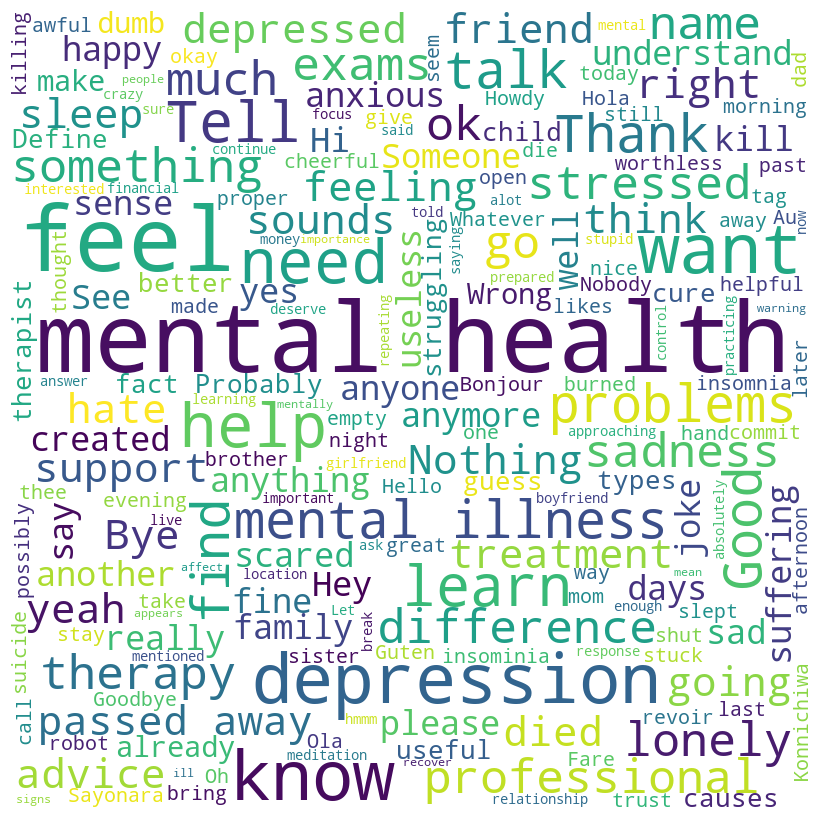

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Extract all patterns from intents
all_patterns = []
for patterns in data['intents']:
    all_patterns.extend(patterns['patterns'])

#Join all patterns into a single string
text = ' '.join(all_patterns)

#Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)

#Plot word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

#Show plot
plt.show()

In [18]:
# Function to recognize emotion in text
def recognize_emotion(text):
    emotions = {
        'stress': ['stressed', 'overwhelmed', 'anxious'],
        'uncertainty': ['unsure', 'confused', 'indecisive'],
        'joy': ['happy', 'joyful', 'excited', 'pleased', 'cheerful'],
        'sadness': ['sad', 'unhappy', 'depressed', 'melancholy', 'gloomy','isolated'],
        'anger': ['angry', 'irritated', 'frustrated', 'outraged', 'furious']
    }
    for emotion, keywords in emotions.items():
        for keyword in keywords:
            if keyword in text.lower():
                return emotion
    return 'neutral'

In [19]:
import tensorflow
from tensorflow import keras
from sklearn.linear_model import SGDClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout
from tensorflow.keras.utils import plot_model

model = Sequential()
model.add(Input(shape=(padded_sequences.shape[1],)))
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, mask_zero=True))
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32))
model.add(LayerNormalization())
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(encoded_labels)), activation="softmax"))
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 18, 100)             │          32,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 18, 32)              │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ (None, 18, 32)              │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 18, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_6                │ (None, 18, 32)              │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_7                │ (None, 32)                  │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_8                │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_9                │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 87)                  │          11,223 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,727 (385.65 KB)

 Trainable params: 98,727 (385.65 KB)

 Non-trainable params: 0 (0.00 B)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [24]:
model_history = model.fit(x=padded_sequences,
                          y=encoded_labels,
                          batch_size=30,
                          epochs=120)

Epoch 1/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9979 - loss: 0.0067
Epoch 2/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9932 - loss: 0.0177
Epoch 3/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9911 - loss: 0.0111
Epoch 4/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9950 - loss: 0.0078
Epoch 5/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 6/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9985 - loss: 0.0058
Epoch 7/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9991 - loss: 0.0075
Epoch 8/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0081
Epoch 9/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9991 - loss: 0.0038
Epoch 10/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9985 - loss: 0.0046  
Epoch 11/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 12/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9950 - 

In [22]:
import re
import random

def model_response(query): 
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', query)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)
        
    x_test = tokenizer.texts_to_sequences(text)
    x_test = np.array(x_test).squeeze()
    x_test = pad_sequences([x_test], padding='post', maxlen=padded_sequences.shape[1])
    y_pred = model.predict(x_test)
    y_pred = y_pred.argmax()
    tag = label_encoder.inverse_transform([y_pred])[0]
    responses = df[df['tag'] == tag]['responses'].values[0]
    emotion = recognize_emotion(query)

    
    print("Emotion: {}".format(emotion))
    

    print("you: {}".format(query))
    print("model: {}".format(random.choice(responses)))

In [23]:
# Define queries
query1 = "who are you?"
query2 = "I have PTSD?"

# Call the model_responce function with each query
model_response(query1)
model_response(query2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
Emotion: neutral
you: who are you?
model: Call me Pandora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Emotion: neutral
you: I have PTSD?
model: Take a deep breath and gather your thoughts. Go take a walk if possible. Stay hydrated


In [17]:
query3 = "i am Lost"
model_response(query3)

1/1 [==============================] - 0s 21ms/step
Emotion: neutral
you: i am Lost
model: Why do you think you feel this way?


In [18]:
query4 = "I dont know just feeling this way"
model_response(query4)

1/1 [==============================] - 0s 22ms/step
Emotion: neutral
you: I dont know just feeling this way
model: I understand how you feel. Don't put yourself down because of it.


In [19]:
query5 = "why am i feeling isolated"
model_response(query5)

1/1 [==============================] - 0s 21ms/step
Emotion: sadness
you: why am i feeling isolated
model: It'll all be okay. This feeling is only momentary.


In [20]:
query6 = "I am feeling isolated"
model_response(query6)

1/1 [==============================] - 0s 21ms/step
Emotion: sadness
you: I am feeling isolated
model: How long have you been feeling this way?


In [ ]:
query7 = "what is a therapist?"
model_response(query7)

: 

In [ ]:
query8 = " how do i know i have Depression "
model_response(query8)

: 

In [ ]:
query5 = "who are you?"
model_response(query5)

: 

In [ ]:
query10 = "who are you?"
model_response(query10)

: 

In [ ]:
query5 = "i am feeling suicidal"
model_response(query5)

: 

In [ ]:
query12 = "because nothing is going right in my life"
model_response(query12)

: 

In [ ]:
query13 = "no not yet"
model_response(query13)

: 

In [ ]:
query14 = "i was feeling good "
model_response(query14)

: 

In [ ]:
query13 = "no not yet"
model_response(query13)

: 

In [ ]:
query15 = "Suicidal thoughts"
model_response(query15)

: 

In [ ]:
query16 = "i want to kill someone"
model_response(query16)

: 

In [ ]:
query16 = "i am sad"
model_response(query16)

: 

In [ ]:
query16 = "Oh My god,I just want to kill myself"
model_response(query16)

: 

In [ ]:
query17 = "I'm sorry, I couldn't understand your concern"
model_response(query17)

: 

: 